In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# Metric Preference Learner

In [2]:
class MetricPrefLearner(nn.Module):
    
    def __init__(self, dim_feature, num_users, items):
        '''
        items shape: np.array (dim_feature, num_items)
        '''
        super().__init__()
        self.dim_feature = dim_feature
        self.num_users = num_users
        self.items = items
        self.us = nn.Parameter(torch.randn((self.dim_feature, self.num_users)))

    def assignModel(self, init_model):
        '''
        Use whatever model you like
        One Condition must be satisfied: input_dim == output_dim == dim_feature
        '''
        self.model = init_model

    def forward(self, x):
        '''
        x shape: (user_id, (item_i, item_j))
        '''
        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        x_is, x_js = torch.Tensor(self.items[:,x_is]), torch.Tensor(self.items[:,x_js])
        us_k_track =self.us[:,user_ids]
        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        ele_1 = self.model(x_is_minus_us)
        ele_2 = self.model(x_js_minus_us)
        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        return delta


# write your program here

In [29]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from mlp import projector
import dataset

In [30]:
############ normal dataset ################
pms = {'d': 128, 'r': 128, 'n': 1000,'N': 100, 'm':300, 'noise_type':'none', 'noise_param':None, 'X':None}
N = pms['N']

normal_dataset = dataset.Dataset(dataset_type='Normal', d=pms['d'], 
                                 r=pms['d'], n=pms['n'], 
                                 N=pms['N'], m=pms['m'], 
                                 noise_type=pms['noise_type'], 
                                 noise_param=pms['noise_param'], X=None)
normal_data = normal_dataset.getAllData()

items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=0.75)

In [31]:
############ hyperparameters ################
epochs = 100
bs = 32
lr = 1e-2
momentum = 0.9
weight_decay = 0.001

In [32]:
############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [33]:
############ initialize the model and the learner################
net = projector(feature_dim=128, num_layer=1, num_class=128, bias_ind=False)
learner = MetricPrefLearner(dim_feature=128, num_users=100, items=items)
learner.assignModel(net)

In [34]:
############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    
    probabilities = logistic(targets * predictions)
    # print(probabilities)
    nll = -torch.sum(torch.log(probabilities))
    # print(nll)
    return nll

loss_fn = hinge_loss
optimizer = torch.optim.Adam(learner.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(learner.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)

In [35]:
def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            optimizer.zero_grad()
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            # calculate the relative_metric_error
            L = net.layers.weight
            relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
            train_stats['relative_metric_error_record'].append(relative_metric_error.item())
            # calculate the relative_ideal_point_error
            relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
            train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/bs)
            loss.backward()
            optimizer.step()
        val_stat = val(net,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(net,loss_fn,test_loader):
    total_val_samples = len(test_dataloader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat


In [36]:
train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs)

100%|██████████| 100/100 [00:54<00:00,  1.84it/s, test_accu=0.819]


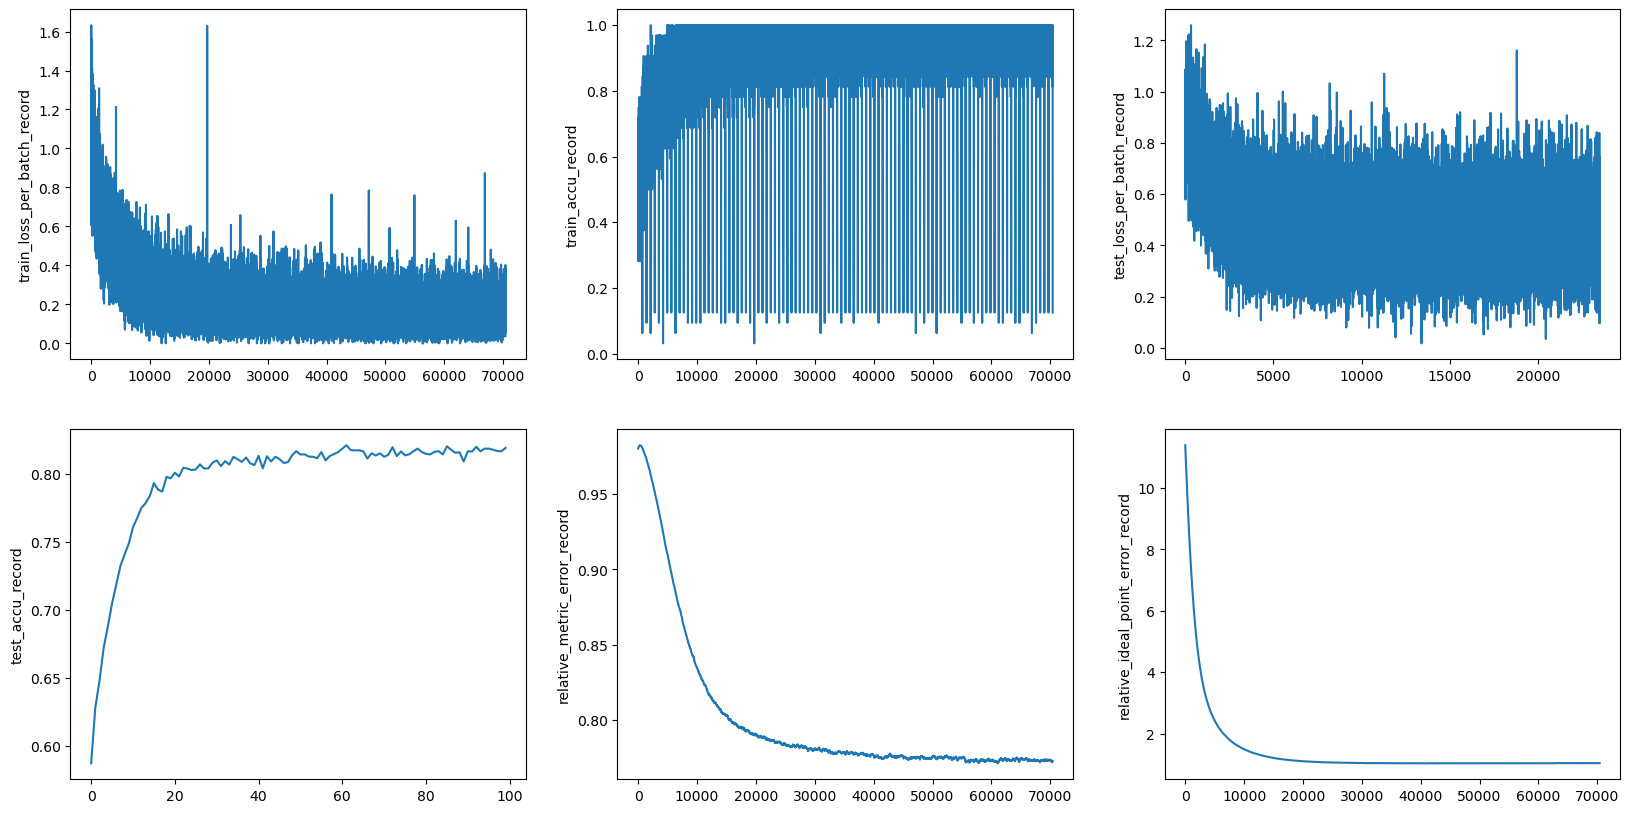

In [37]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)